# Workshop Tutorial: Optimizing Computations

This tutorial covers the parts of PHOEBE that are computationally the most expensive and how to minimize this cost for individual systems.

This interactive workshop tutorial covers many of the same topics as the corresponding online tutorials:

* [Eclipse Detection](http://phoebe-project.org/docs/2.4/tutorials/eclipse.ipynb)
* [Eccentricity & Volume Conservation](http://phoebe-project.org/docs/2.4/tutorials/ecc.ipynb)
* [Reflection & Heating (irrad_frac_refl_bol, irrad_frac_lost_bol, ld_func_bol, ld_coeffs_bol)](http://phoebe-project.org/docs/2.4/tutorials/reflection_heating.ipynb)
* [Reflection & Heating: Lambert Scattering (irrad_method='horvat' vs 'wilson')](http://phoebe-project.org/docs/2.4/tutorials/irrad_method_horvat.ipynb)
* [Detached Binary: Roche vs Rotstar](http://phoebe-project.org/docs/2.4/examples/detached_rotstar.ipynb)
* [Rossiter-McLaughlin Effect (RVs)](http://phoebe-project.org/docs/2.4/examples/rossiter_mclaughlin.ipynb)
* [Finite Time of Integration (LCs - exptime, fti_method, fti_oversample)](http://phoebe-project.org/docs/2.4/tutorials/fti.ipynb)

In addition, see the following document on optimizing the performance of the PHOEBE frontend itself in scripts (this will _not_ affect the speed within `run_compute` or `run_solver`):

* [Advanced: Optimizing Performance with PHOEBE](http://phoebe-project.org/docs/2.4/tutorials/optimizing.ipynb)

# Setup

As usual, we start with the imports, logger setup, and default binary initialization:

In [1]:
import phoebe
from phoebe import u, c
logger = phoebe.logger(clevel='WARNING')
b = phoebe.default_binary()

Thu, 09 Jun 2022 15:35 BUNDLE       WARNING importing from an older version (2.4) of PHOEBE to PHOEBE 2.4.  This may take some time.  Please check all values.


Next, we add two datasets: a light curve and a radial velocity curve:

In [2]:
b.add_dataset('lc', compute_times=phoebe.linspace(0, 1, 101))
b.add_dataset('rv', compute_times=phoebe.linspace(0, 1, 26))

<ParameterSet: 83 parameters | contexts: compute, dataset, constraint, figure>

# Compute Times/Phases

With the exception of dynamics (dynamical RVs and orbits), PHOEBE computations scale with the number of data points (roughly linearly after some up-front costs).  As discussed in previous tutorials (see [Tutorial: Datasets](./Tutorial_03_datasets.ipynb) and [Tutorial: Time and Phase](./Tutorial_05_time_and_phase.ipynb)), the model can be computed at different times than the input observations.  

For systems without time-dependence (no apsidal motion, etc), it can therefore be quite advantageous to compute the forward model sampled in phase-space and interpolate when comparing to the observations (PHOEBE will handle this interpolation for you).  Just check to make sure that you sample sufficiently in phase that the linear interpolation won't introduce any systematics.

# Number of Triangles

Similarly, the expense of building meshes scales with the number of triangles (and so does the expense of irradiation which we return to later).  The default number of triangles in PHOEBE is quite low, for this reason.  However, an insufficient number of triangles can result in numerical noise both on the horizon and during the eclipse.  In some cases, it may be worth some extra up-front effort to determine the (approximate) minimum number of triangles needed to achieve the minimum signal-to-noise ration suitable for the data.

# Eclipse Detection

For more details, see [Eclipse Detection](http://phoebe-project.org/docs/2.4/tutorials/eclipse.ipynb).

By default, at each time point, PHOEBE will check to see if the maximum radius of all meshes would cause an eclipse in the sky projection.  If so, the complete eclipse algorithm is called to determine the visibility of each triangle, and if not, triangles are only checked to determine if facing towards or away from the observer (horizon detection).  In cases where you _know_ eclipses will never occur (ellipsoidal variables, for example), this can be optimized slightly by telling PHOEBE to skip this check and only use horizon detection. 

In [5]:
print(b.get_parameter(qualifier='eclipse_method'))

Parameter: eclipse_method@phoebe01@compute
                       Qualifier: eclipse_method
                     Description: Type of eclipse algorithm
                           Value: native
                         Choices: native, only_horizon
                  Constrained by: 
                      Constrains: None
                      Related to: None



# Eccentricity

For more details, see [Eccentricity & Volume Conservation](http://phoebe-project.org/docs/2.4/tutorials/ecc.ipynb).

Eccentricity on its own does not add significant expense - however, it does when in combination with irradiation or distorted stars (both of which are enabled by default).  Whenever an orbit has a non-zero eccentricity, the stars must be re-meshed at each time point and irradiation must be re-computed.

Although it is usually a good idea to at least marginalize over eccentricity for the final parameter uncertainties (more on this in the second week), if a system can be assumed to be circular or shows no signs of significant eccentricity, setting the eccentricity to be exactly zero can minimize costs significantly.

In [6]:
print(b.get_parameter(qualifier='ecc'))

Parameter: ecc@binary@component
                       Qualifier: ecc
                     Description: Eccentricity
                           Value: 0.0
                  Constrained by: 
                      Constrains: t0_perpass@binary@component, t0_ref@binary@component, ecosw@binary@component, esinw@binary@component, requiv_max@primary@component, requiv_max@secondary@component
                      Related to: t0_supconj@binary@component, period@binary@component, per0@binary@component, dpdt@binary@component, dperdt@binary@component, t0@system, t0_perpass@binary@component, t0_ref@binary@component, ecosw@binary@component, esinw@binary@component, q@binary@component, syncpar@primary@component, sma@binary@component, incl@primary@component, long_an@primary@component, incl@binary@component, long_an@binary@component, requiv_max@primary@component, syncpar@secondary@component, incl@secondary@component, long_an@secondary@component, requiv_max@secondary@component



# Reflection & Heating (irrad_method)

For more details, see [Reflection & Heating (irrad_frac_refl_bol, irrad_frac_lost_bol, ld_func_bol, ld_coeffs_bol)](http://phoebe-project.org/docs/2.4/tutorials/reflection_heating.ipynb) and [Reflection & Heating: Lambert Scattering (irrad_method='horvat' vs 'wilson')](http://phoebe-project.org/docs/2.4/tutorials/irrad_method_horvat.ipynb).

In addition to meshing and eclipse detection, irradiation is the next most common culprit in computation expense. In cases where irradiation can safely be ignored, it can be disabled entirely by setting `irrad_method='none'`.  This will only result in marginal gains for circular synchronous systems, but can result in significant savings for eccentric and/or asynchronous systems.

In [7]:
print(b.get_parameter(qualifier='irrad_method'))

Parameter: irrad_method@phoebe01@compute
                       Qualifier: irrad_method
                     Description: Which method to use to handle all irradiation effects (reflection, redistribution)
                           Value: horvat
                         Choices: none, wilson, horvat
                  Constrained by: 
                      Constrains: None
                      Related to: None



# Stellar Distortion (distortion_method)

For more details, see [Detached Binary: Roche vs Rotstar](http://phoebe-project.org/docs/2.4/examples/detached_rotstar.ipynb)

In cases where stellar distortion is negligible, stars can be meshed with either a rotating star or spherical star equipotential in place of the full roche treatment.  Similarly to irradiation, this can result in significant savings for eccentric systems as otherwise the instantaneous equipotential needs to be determined at each time point to conserve volume and the stars need to be re-meshed.

Note: there is a `distortion_method` parameter per-component.

In [8]:
print(b.get_parameter(qualifier='distortion_method', component='primary'))

Parameter: distortion_method@primary@phoebe01@compute
                       Qualifier: distortion_method
                     Description: Method to use for distorting stars
                           Value: roche
                         Choices: roche, rotstar, sphere, none
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: mesh_method:marching,hierarchy.is_meshable:true



# Dynamical RVs

For more details, see [Rossiter-McLaughlin Effect (RVs)](http://phoebe-project.org/docs/2.4/examples/rossiter_mclaughlin.ipynb).

By default, PHOEBE will compute RVs by populating velocities at each surface element and doing an intensity-weighted average over the visible elements.  This allows for Rossiter-McLaughlin effect to be synthesized.  However, in cases where Rossiter-McLaughlin is not important, dynamical RVs can be used instead which use the center of mass velocities.

If the mesh is already being created and populated for an LC _at the same time_, then flux-weighted RVs do not add significant additional overhead.

Note: there is an `rv_method` parameter per-component.  However, as the mesh will need to be populated if any are set to flux-weighted, little is to be gained from an optimization perspective by not setting all to 'dynamical'.

In [9]:
print(b.get_parameter(qualifier='rv_method', component='primary'))

Parameter: rv_method@primary@phoebe01@compute
                       Qualifier: rv_method
                     Description: Method to use for computing RVs (must be flux-weighted for Rossiter-McLaughlin effects)
                           Value: flux-weighted
                         Choices: flux-weighted, dynamical
                  Constrained by: 
                      Constrains: None
                      Related to: None



# Integration Time

For more details, see [Finite Time of Integration (LCs - exptime, fti_method, fti_oversample)](http://phoebe-project.org/docs/2.4/tutorials/fti.ipynb)

Although we have not discussed this during the workshop, PHOEBE allows for oversampling each synthetic time over the observational exposure time (where the number of samples that will be averaged is provided in `fti_oversample`).

If the exposure time is short relative to the orbital period, accounting for this in the synthetic model will have very little affect on the model light curves and likely is not worth the increased expense (which will scale linearly with `fti_oversample`).

Note that oversampling will only occur if the `exptime` is set in the dataset.



In [10]:
print(b.get_parameter(qualifier='fti_method'))

Parameter: fti_method@phoebe01@compute
                       Qualifier: fti_method
                     Description: How to handle finite-time integration (when non-zero exptime)
                           Value: none
                         Choices: none, oversample
                  Constrained by: 
                      Constrains: None
                      Related to: None



In [11]:
b.set_value(qualifier='fti_method', value='oversample')

In [12]:
print(b.get_parameter(qualifier='fti_oversample'))

Parameter: fti_oversample@phoebe01@compute
                       Qualifier: fti_oversample
                     Description: Number of times to sample per-datapoint for finite-time integration
                           Value: 5
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: fti_method:oversample



# Determining Safe Approximations

In order to set any of these approximations, we first want to make sure that the influence of that choice will have no detrimental impact on the resulting model.  In any real case, there will be some impact, of course.  But we can compute forward models both with and without the effect and compare the magnitude of the difference to either the amplitude of the signal or of the observational uncertainties.

In [13]:
b.run_compute(model='full')

100%|██████████| 101/101 [00:01<00:00, 54.60it/s]


<ParameterSet: 7 parameters | kinds: lc, rv>

In [14]:
b.run_compute(irrad_method='none', model='irrad_off')

100%|██████████| 101/101 [00:01<00:00, 57.11it/s]


<ParameterSet: 7 parameters | kinds: lc, rv>

In [15]:
b.run_compute(distortion_method='sphere', model='distortion_off')

100%|██████████| 101/101 [00:03<00:00, 27.60it/s]


<ParameterSet: 7 parameters | kinds: lc, rv>

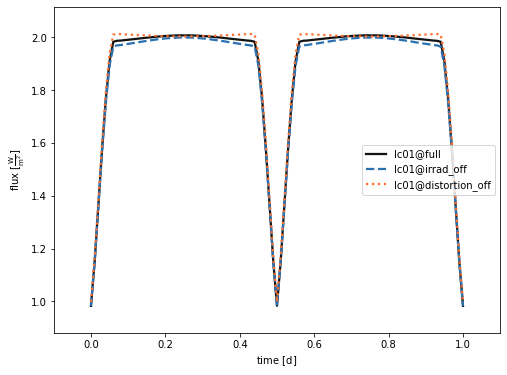

In [16]:
_ = b.plot(kind='lc', legend=True, show=True)

Currently there is no built-in ability to compare two models quantitatively, and there are many different ways you might imagine doing this (relative to the amplitude of the eclipse signal, relative to the uncertainties in observations, etc), but here we'll just quickly plot the relative residuals and check the maximum relative differences.

In [17]:
import numpy as np
import matplotlib.pyplot as plt

times = b.get_value('times', dataset='lc01', model='full')
fluxes_full = b.get_value('fluxes', model='full')
fluxes_irrad_off = b.get_value('fluxes', model='irrad_off')
fluxes_distortion_off = b.get_value('fluxes', model='distortion_off')

fluxes_irrad_rel = (fluxes_irrad_off - fluxes_full)/fluxes_full
fluxes_distortion_rel = (fluxes_distortion_off - fluxes_full)/fluxes_full

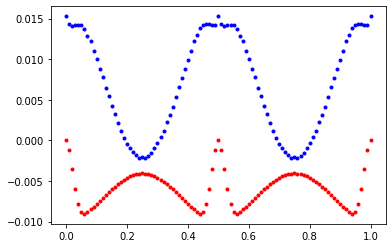

In [18]:
_ = plt.plot(times, fluxes_irrad_rel, 'r.')
_ = plt.plot(times, fluxes_distortion_rel, 'b.')

In [19]:
np.max(abs(fluxes_irrad_rel))

0.00906021771392527

**IMPORTANT**: if you're fitting a system and applying any of these approximations, it is important to check the validity throughout the process (and particularly on the final solution - and then of course be transparent in any publications).  

# Exercise

Take any of the systems you've built and determine which (if any) expensive effects can safely be ignored.